# tensorFlow物件偵測的 Demo

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
print('成功import12')

成功import12


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
print('env ok')

env ok


## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util
# 內含有將物件偵測結果視覺化的API
from utils import visualization_utils as vis_util
print('ok')

ok


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
# TF已經訓練好的模型名稱
# 應該是最快的Model
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'

# 中等速度的Model
# 第一張圖處理14.156，後面的圖處理每張大約花4~5秒的時間。
# MODEL_NAME = 'rfcn_resnet101_coco_11_06_2017'

# # 賭賭看改用這個比較慢的模型，可以跑但是很慢，這是最慢的模型一張圖要花40多秒，最猛的模型
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017'

# TF已經訓練好的模型檔案(本身是一個tar.gz的壓縮檔)
MODEL_FILE = MODEL_NAME + '.tar.gz'

# 這個TF訓練好模型 所在網站的目錄名稱
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# TF實際用來做物件偵測的模型 
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# 這個模型對應到的種類txt檔，內涵每個種類的索引&名稱
# 之後物件偵測得到的資訊會是索引，所以需要此文件參考名稱
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# 預設模型種類數量 為90種
NUM_CLASSES = 90
print('Model preparation is ok...')

Model preparation is ok...


## Download Model (如果之前下載過模組，那該這個區塊可以不用再執行一次)

In [5]:
# opener = urllib.request.URLopener()
# # opener.retrieve(下載的檔案來源, 下載的檔案存放的本地位址)
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#     file_name = os.path.basename(file.name)
#     if 'frozen_inference_graph.pb' in file_name:
#         tar_file.extract(file, os.getcwd())
# print('Download Model is ok', os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names,

so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  

Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = (label_map_util.convert_label_map_to_categories(
    label_map, 
    max_num_classes=NUM_CLASSES, 
    use_display_name=True))

category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'person'}, 2: {'id': 2, 'name': 'bicycle'}, 3: {'id': 3, 'name': 'car'}, 4: {'id': 4, 'name': 'motorcycle'}, 5: {'id': 5, 'name': 'airplane'}, 6: {'id': 6, 'name': 'bus'}, 7: {'id': 7, 'name': 'train'}, 8: {'id': 8, 'name': 'truck'}, 9: {'id': 9, 'name': 'boat'}, 10: {'id': 10, 'name': 'traffic light'}, 11: {'id': 11, 'name': 'fire hydrant'}, 13: {'id': 13, 'name': 'stop sign'}, 14: {'id': 14, 'name': 'parking meter'}, 15: {'id': 15, 'name': 'bench'}, 16: {'id': 16, 'name': 'bird'}, 17: {'id': 17, 'name': 'cat'}, 18: {'id': 18, 'name': 'dog'}, 19: {'id': 19, 'name': 'horse'}, 20: {'id': 20, 'name': 'sheep'}, 21: {'id': 21, 'name': 'cow'}, 22: {'id': 22, 'name': 'elephant'}, 23: {'id': 23, 'name': 'bear'}, 24: {'id': 24, 'name': 'zebra'}, 25: {'id': 25, 'name': 'giraffe'}, 27: {'id': 27, 'name': 'backpack'}, 28: {'id': 28, 'name': 'umbrella'}, 31: {'id': 31, 'name': 'handbag'}, 32: {'id': 32, 'name': 'tie'}, 33: {'id': 33, 'name': 'suitcase'}, 34: {'id': 34, 'name'

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
import time 

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'

TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'dog{}.jpg'.format(i)) for i in range(0, 100) ]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:

images_obj_classes = []
images_obj_coordinates = []
images_obj_scores = []

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    for image_path in TEST_IMAGE_PATHS:
      tStart = time.time()
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
      # Each box represents a part of the image where a particular object was detected.
      boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
      # Each score represent how level of confidence for each of the objects.
      # Score is shown on the result image, together with the class label.
      scores = detection_graph.get_tensor_by_name('detection_scores:0')
      classes = detection_graph.get_tensor_by_name('detection_classes:0')
      num_detections = detection_graph.get_tensor_by_name('num_detections:0')
      # Actual detection.
      (boxes, scores, classes, num_detections) = sess.run(
          [boxes, scores, classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      
#     # 印出每個物件的位置.分數.種類
#       print('boxes[0]:', boxes[0])
#       print('scores[0]:', scores[0])
#       print('classes:', classes)
#       print('\n\n\n')
#       for i in range(2):
#           print("-----------------------------------------------------")
#       print('---------------- %s--------------' % image_path)      
#       for i in range(2):
#         print("-----------------------------------------------------")
      # 分數高於0.5的才可以視為相符
      obj_length = len([x for x in scores[0] if x > 0.6])
      width, height = image.size
    
      # 第一實驗魔改_Begin 該圖片所有的物件種類   
      all_objs = classes[0]
      ok_objs = all_objs[0:obj_length]
      objs_classes = set(ok_objs)
    
      # Result 1 對應原始物件索引陣列的字典(Key為類別名， Value為對應原始陣列的物件索引陣列)
      img_classes = dict()

      for obj_class in objs_classes:
        img_classes[category_index[obj_class]['name']] = len(np.nonzero(ok_objs == obj_class)[0])
#         print(category_index[obj_class]['name'], ':', len(np.nonzero(ok_objs == obj_class)[0]))
#         print('種類:', category_index[obj_class]['name'])
#         print(np.nonzero(ok_objs == obj_class)[0], '有', len(np.nonzero(ok_objs == obj_class)[0]),'個') 

      # Result 2 原始物件的標記位置陣列[(x1, y1, x2, y2)]
      img_obj_coordinates = boxes[0][0:obj_length]
        
      # Result 3 原始物件的相似分數陣列
      img_obj_scores = scores[0][0:obj_length]

      # 標示每個圖片上所有的物件Visualization of the results of a detection.  
#     # 如果要顯示圖片在ipynb，這個區塊可以取消註解 
#       vis_util.visualize_boxes_and_labels_on_image_array(
#           image_np,
#           np.squeeze(boxes),
#           np.squeeze(classes).astype(np.int32),
#           np.squeeze(scores),
#           category_index,
#           use_normalized_coordinates=True,
#           line_thickness=4)
#       plt.figure(figsize=IMAGE_SIZE)
#       plt.imshow(image_np)
#       # 如果要顯示圖片在ipynb，這個區塊可以取消註解 
      # 第一實驗魔改_End
      
      images_obj_classes.append(img_classes)
      images_obj_coordinates.append(img_obj_coordinates)
      images_obj_scores.append(img_obj_scores)
        
      tEnd = time.time()
      print('每個圖片建立檔案結束:', tEnd - tStart)
print('結束')

每個圖片建立檔案結束: 4.110505104064941
每個圖片建立檔案結束: 0.4286649227142334
每個圖片建立檔案結束: 0.17743301391601562
每個圖片建立檔案結束: 0.20835494995117188
每個圖片建立檔案結束: 0.47170186042785645
每個圖片建立檔案結束: 0.1654500961303711
每個圖片建立檔案結束: 0.322145938873291
每個圖片建立檔案結束: 0.16386103630065918
每個圖片建立檔案結束: 0.24124407768249512
每個圖片建立檔案結束: 0.21681499481201172
每個圖片建立檔案結束: 0.34340500831604004
每個圖片建立檔案結束: 0.2113041877746582
每個圖片建立檔案結束: 0.3279759883880615
每個圖片建立檔案結束: 0.24828696250915527
每個圖片建立檔案結束: 0.19082403182983398
每個圖片建立檔案結束: 0.32500505447387695
每個圖片建立檔案結束: 0.3380270004272461
每個圖片建立檔案結束: 0.3107740879058838
每個圖片建立檔案結束: 0.327498197555542
每個圖片建立檔案結束: 0.6074650287628174
每個圖片建立檔案結束: 0.32628393173217773
每個圖片建立檔案結束: 0.31257081031799316
每個圖片建立檔案結束: 1.0218849182128906
每個圖片建立檔案結束: 0.5679929256439209
每個圖片建立檔案結束: 0.32314085960388184
每個圖片建立檔案結束: 0.33861398696899414
每個圖片建立檔案結束: 0.34661412239074707
每個圖片建立檔案結束: 0.39862990379333496
每個圖片建立檔案結束: 0.3035259246826172
每個圖片建立檔案結束: 0.3860349655151367
每個圖片建立檔案結束: 0.28920578956604004
每個圖片建立檔案結束: 0.30107402801

b圖跟 以下索引的A組圖 配對成功:
[0, 16, 20, 24, 26, 28, 31, 34, 46, 47, 53, 60, 63, 65, 67, 70]


 B組....
------ 秀出B圖的物件字典 ------
{'dog': 1, 'person': 1}
------ 秀出B圖的 物件相似分數陣列 ------
b_obj_scores[0] = 0.8854013085365295
b_obj_scores[1] = 0.7975534200668335
------ 秀出B圖的 物件座標陣列 ------
a_obj_coordinates[0] = [ 0.4337334   0.28162548  0.85484308  0.79352403]
a_obj_coordinates[1] = [ 0.00353029  0.32657272  0.5304637   0.60259175]

第二實驗_比對結束: 0.002992868423461914
b_image讀取name
width: 375
height 500
162 140 320 396
1 163 198 301
-=====================================
-=====================================
-=====================================
-=====================================
a_obj_coordinates[0]
物件：  99 166 345 408
物件：  212 98 326 233
a_obj_coordinates[16]
物件：  47 219 265 378
物件：  137 0 351 290
a_obj_coordinates[20]
物件：  99 42 343 228
物件：  79 177 352 457
a_obj_coordinates[24]
物件：  151 39 324 366
物件：  73 105 312 415
a_obj_coordinates[26]
物件：  63 177 355 329
物件：  233 258 375 379
a_obj_coordinates[28

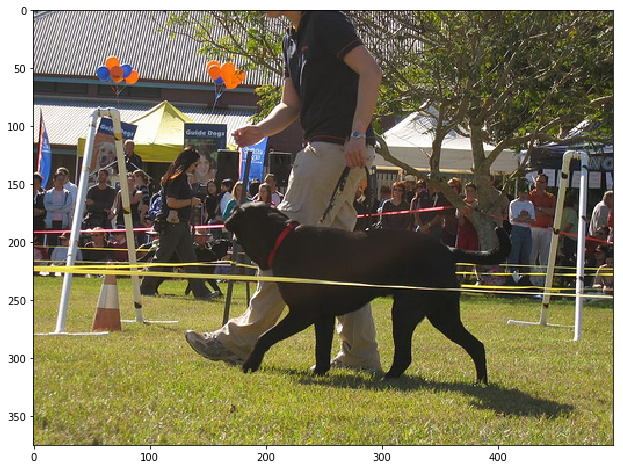

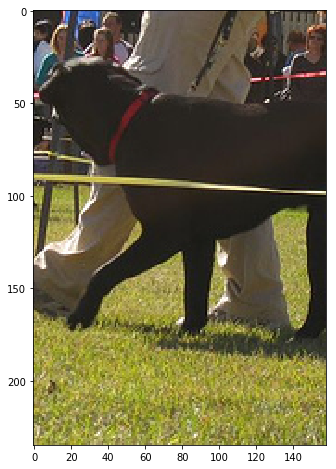

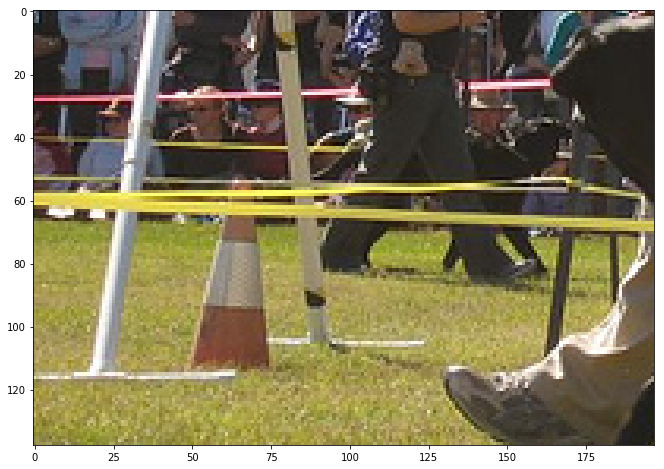

In [23]:
import cv2


# 實驗4
# 此為一對多的實驗
# 讀取一個圖片，從20張圖片挑出符合物件條件&色彩特徵相似的的圖片。
tStart = time.time()

# 取樣A組的圖片數，ex: A_SIZE = 76，代表A組的突圍dog0.jpg~dog75.jpg， B組圖則是dog76.jpg
A_SIZE = 77

# A組圖代表 前A_SIZE個 圖片的物件字典, 相似分數, 物件座標
a_obj_data = images_obj_classes[0:A_SIZE]
a_obj_scores = images_obj_scores[0:A_SIZE]
a_obj_coordinates = images_obj_coordinates[0:A_SIZE]

# B組圖代表 第A_SIZE 圖片的物件字典, 相似分數, 物件座標
b_obj_data = images_obj_classes[A_SIZE]
b_obj_scores = images_obj_scores[A_SIZE]
b_obj_coordinates = images_obj_coordinates[A_SIZE]

# b_match_a，為圖片B 跟 A組圖片們物件數比對成功串列的串列。
b_match_a = list()
b_objs = b_obj_data
for a_key, a_objs in enumerate(a_obj_data):
    if b_objs == a_objs:
        b_match_a.append(a_key)
print('b圖跟 以下索引的A組圖 配對成功:')
print(b_match_a)

    

print('\n\n B組....')
print('------ 秀出B圖的物件字典 ------')
print(b_obj_data)    
# 秀出B圖的 物件相似分數陣列
print('------ 秀出B圖的 物件相似分數陣列 ------')
for b_key, b_scores in enumerate(b_obj_scores):
    print('b_obj_scores[{}] = {}'.format(b_key, b_scores))
# 秀出B圖的 物件座標陣列
print('------ 秀出B圖的 物件座標陣列 ------')
for b_key, b_coordinates in enumerate(b_obj_coordinates):
    print('a_obj_coordinates[{}] = {}'.format(b_key, b_coordinates))

# print('\n\nＡ組....')

# # 秀出Ａ組每張圖的 物件相似分數陣列
# for a_key, a_scores in enumerate(a_obj_scores):
#     print('a_obj_scores[{}] = {}'.format(a_key, a_scores))

# # 秀出Ａ組每張圖的 物件座標陣列
# for a_key, a_coordinates in enumerate(a_obj_coordinates):
#     print('a_obj_coordinates[{}] = {}'.format(a_key, a_coordinates))

tEnd = time.time()
print('\n第二實驗_比對結束:', tEnd - tStart)

print('b_image讀取name')
b_image_name = 'test_images/dog{}.jpg'.format(A_SIZE)
b_image = cv2.imread(b_image_name)

width, height = image.size
print('width:', width)
print('height', height)

# # 展示B圖片
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(cv2.cvtColor(b_image, cv2.COLOR_BGR2RGB))

# b圖物件的直方圖串列
b_obj_hist = list()

#  迭代 b圖片的所有物件
for b_key, b_coordinates in enumerate(b_obj_coordinates):
    y1 = int(b_coordinates[1] * height)
    y2 = int(b_coordinates[3] * height)
    x1 = int(b_coordinates[0] * width)
    x2 = int(b_coordinates[2] * width)
    print(x1, y1, x2, y2)
    obj_img = b_image[y1:y2, x1:x2]

    # 展示B圖物件的截取圖
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB))
    
    # 產生B圖物件的直方圖
    obj_hsv = cv2.cvtColor(obj_img, cv2.COLOR_BGR2HSV)
    obj_hist = cv2.calcHist([obj_hsv], [0, 1], None, [30, 25], [0,180,0,256])
    
# #     # 展示B圖物件的直方圖
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(obj_hist)
    
    # 添加B圖物件的直方圖到 b_obj_hist裡面。
    b_obj_hist.append(obj_hist)

    
    
print('-=====================================')
print('-=====================================')
print('-=====================================')
print('-=====================================')

# A組所有圖片的物件直方圖串列的串列
imgs_hist_list = list()

for a_img_index in b_match_a:
    # a組的單張圖片＿圖檔名稱
    a_imag_name = 'test_images/dog{}.jpg'.format(a_img_index)
    
    # a組的單張圖片
    a_image = cv2.imread(a_imag_name)
    width, height = image.size
    
    # 存放 a組單張圖片的所有物件直方圖的串列
    a_obj_hist = list()
    
    print('a_obj_coordinates[{}]'.format(a_img_index))

    # 迭代 a組單張圖片的所有物件
    for a_key, a_coordinates in enumerate(a_obj_coordinates[a_img_index]):
        y1 = int(a_coordinates[1] * height)
        y2 = int(a_coordinates[3] * height)
        x1 = int(a_coordinates[0] * width)
        x2 = int(a_coordinates[2] * width)
        print('物件： ', x1, y1, x2, y2)
        # a組單張圖片中某個物件截圖
        obj_img = a_image[y1:y2, x1:x2]
        
        # 產生a組單張圖片中某個物件的直方圖
        obj_hsv = cv2.cvtColor(obj_img, cv2.COLOR_BGR2HSV)
        obj_hist = cv2.calcHist([obj_hsv], [0, 1], None, [30, 25], [0,180,0,256])
        
        # 將 某個物件的直方圖 添加到 a_obj_hist
        a_obj_hist.append(obj_hist)
    
        # 將第a_img_index張圖的a_obj_hist 添加到 imgs_hist_list
    imgs_hist_list.append(a_obj_hist)
#         # 展示 a組單張圖片中某個物件的直方圖
#         plt.figure()
#         plt.imshow(cv2.cvtColor(a_image, cv2.COLOR_BGR2RGB))

tEnd = time.time()
print('該區塊花費時間:', tEnd - tStart)

# 紀錄... dog60.jpg
# dog6.jpg, dog13.jpg, dog28.jpg, dog69.jpg, dog56.jpg
# 需要修圖軟體(PS, Gimp)把它修正解析度，將向素拉等比例拉大到寬至少有460pxl 

dog75.jpg 和dog76.jpg

len(b_obj_hist) = 2
len(imgs_hist_list) = 16

比對a組的 第0張圖片
0, 0互相比較，相似度為0.14068134042449648
0, 1互相比較，相似度為0.10001498927831988
最高相似度為 0.14068134042449648
1, 0互相比較，相似度為0.11655122799498542
1, 1互相比較，相似度為0.0982313850700998
最高相似度為 0.11655122799498542
平均相似度: 0.12861628420974094 


比對a組的 第16張圖片
0, 0互相比較，相似度為0.031443151681070654
0, 1互相比較，相似度為0.030500874905475123
最高相似度為 0.031443151681070654
1, 0互相比較，相似度為0.14818470196833458
1, 1互相比較，相似度為0.11566915835960379
最高相似度為 0.14818470196833458
平均相似度: 0.08981392682470261 


比對a組的 第20張圖片
0, 0互相比較，相似度為0.2615239909716313
0, 1互相比較，相似度為0.20732818406781017
最高相似度為 0.2615239909716313
1, 0互相比較，相似度為0.3865714419100651
1, 1互相比較，相似度為0.2783130169776587
最高相似度為 0.3865714419100651
平均相似度: 0.3240477164408482 


比對a組的 第24張圖片
0, 0互相比較，相似度為0.20018832911604317
0, 1互相比較，相似度為0.1306489314014623
最高相似度為 0.20018832911604317
1, 0互相比較，相似度為0.3100552979820165
1, 1互相比較，相似度為0.1836280527753547
最高相似度為 0.3100552979820165
平均相似度: 0.25512181354902985 


比對a組的 第26張圖片
0, 0互相比較，相似度為0.38668967265318904
0

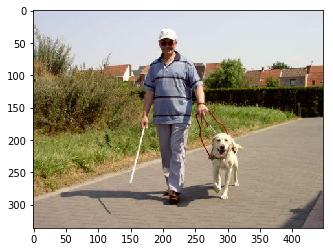

In [33]:
# 先前已經把 直方圖都產生完畢，這邊開始做 直方圖比對。
compare_score_list = list()


# plt.figure()
# plt.imshow(imgs_hist_list[0][1])

print('len(b_obj_hist) =', len(b_obj_hist))
print('len(imgs_hist_list) =', len(imgs_hist_list))

# 基本的直方圖比較，可以比對但太簡單不算精準
# for a_index, a_objs in enumerate(imgs_hist_list):
    
#     compare_sum = 0
#     print('比對a組的 第{}張圖片'.format(b_match_a[a_index]))
#     for a_key, a_boj in enumerate(a_objs):
#         compare_score = cv2.compareHist(a_boj, b_obj_hist[a_key], cv2.HISTCMP_CORREL)
#         print('{} = {}'.format(a_key, compare_score))
#         compare_sum += compare_score
#     compare_score_list.append(compare_sum/len(a_objs))

# compare_max = max(compare_score_list)
# max_index = compare_score_list.index(compare_max)



for a_index, a_objs in enumerate(imgs_hist_list):
    
    compare_sum = 0
    print('\n比對a組的 第{}張圖片'.format(b_match_a[a_index]))
    
    
    for a_key, a_boj in enumerate(a_objs):
        a_compare_b_list = list()
        
        for b_key, b_obj in enumerate(b_obj_hist):
            compare_score = cv2.compareHist(a_boj, b_obj, cv2.HISTCMP_CORREL)
            print('{}, {}互相比較，相似度為{}'.format(a_key, b_key, compare_score))
            a_compare_b_list.append(compare_score)
        print('最高相似度為', max(a_compare_b_list))
        compare_sum += max(a_compare_b_list)
    print('平均相似度:', compare_sum/len(a_objs), '\n')
    
    compare_score_list.append(compare_sum/len(a_objs))

compare_max = max(compare_score_list)
max_index = compare_score_list.index(compare_max)
            


# 結果
print('a組第{}張圖片是與b圖色彩特徵最相似的...，物件色彩特徵相似度高達{:f}%'.format(b_match_a[max_index], compare_max*100))
similar_img_name = 'test_images/dog{}.jpg'.format(b_match_a[max_index])
similar_img = cv2.imread(similar_img_name)

plt.figure()
plt.imshow(cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB))
